# Exercise
請各位使用Siamese訓練比較Omniglot資料集的兩個字是否相同:

Omniglot資料集：
* source有3856個來自不同語言的不同字符，target有659個不同字符
* 每個class有20張不同人手寫的同一個文字的圖片
* 每個task的support是隨機抽1張照片
* query另外1張照片，需推論這張照片與support是否是相同種類字符(e.g. 都是 "人" 這個字)

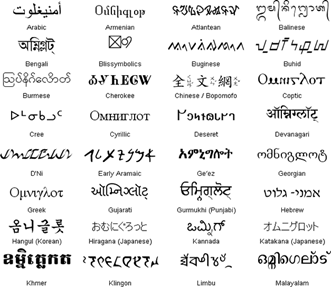

**以下附上圖案讀取的code**

請自行撰寫data loader以及training內容

e.g.
```
# Data loader
def gen(...):
    ...
    return X,y

# 建立模型
...
model = Model(inputs=imgs, outputs=distance)

# 模型訓練
...
model.fit(data_source,...,validation_data=data_source)
```

程式碼部分會做以下部分：
* Data Loader
* 資料抽樣、切分
* 建立模型
* 模型訓練
* 預測結果

# Data Loader
* (meta)batch: 一次訓練BATCH_SIZE個task
* task: 選2人不重複
* sample: 2人資料中選一張當support，還要從剩下19張選一張query

In [1]:
# Colab上的話要下載資料
# !gdown https://drive.google.com/u/1/uc?id=1sSAsIVQl4u_eMWw4t9dfD3gGnHKwAUhz&export=download
# !unzip orl_faces.zip
# !mv orl_faces/ ..

In [2]:
'''Toolboxs'''
import cv2
import re
import os
from os.path import join
import numpy as np
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from functools import partial
from sklearn.model_selection import train_test_split
'''Tensorflow'''
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras import callbacks as cb
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Input, Lambda, Dense, Dropout, \
                           Convolution2D, MaxPooling2D, Flatten,Activation

gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth( device=gpu, enable=True)
if len(gpus)>1:
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{len(gpus)-1}"

先設定讀取圖片程式，這個資料集圖檔讀取方式需自訂，要輸入圖片的和寬、高、最大值，其中header是圖檔的標頭，讀取時要略過

圖片路徑為{orl_faces資料夾}/s1到s40

每個subject的圖片放在不同資料夾

In [3]:
import numpy as np
import cv2

W,H,CH = 64,64,1
def load_img(path, width = W, hight=H):
    img=cv2.imread(path.numpy().decode())[...,0].astype(np.float32)/255.
#     img = read_pgm(path.numpy().decode()).astype(np.float32)/255.
    min_of_shape = np.min(img.shape[:2])
    oh = (img.shape[0] - min_of_shape) // 2
    ow = (img.shape[1] - min_of_shape) // 2
    center_square = np.array([width,hight])// 2
    new_size=(width,hight)
    
    # cropping + resize
    img = img[oh:oh + min_of_shape, ow:ow + min_of_shape]
    img=np.expand_dims(cv2.resize(img, new_size),-1)
    return tf.constant(img-0.5)
SUFFIX='.png'


先設好要使用的參數

In [4]:
WAYS = 2
QUERIES=1
BATCH_SIZE=64

首先列出sourse跟target有哪些classes

In [5]:
np.random.seed(2021)
tf.random.set_seed(2021)
DATA_ROOT=".."
# DATA_ROOT=join("..","..","data")
# DATA_ROOT="I:\AIA Small Data\datasets"
all_classes = glob(join(DATA_ROOT,"Omniglot_splited","images_background","*","*"))
source_classes,target_classes=train_test_split(all_classes,test_size=0.2)
sorce_len=len(source_classes)
target_len=len(target_classes)
print(f"total {len(all_classes)} classes=source {sorce_len} + target {target_len} classes")

total 3856 classes=source 3084 + target 772 classes


確認各個class中至少有幾張，沒有個兩張是不行的，因為就不能比了

In [6]:
min([len(glob(join(sdir,'*'+SUFFIX))) for sdir in source_classes])

20

建立每個人的資料loader

In [7]:
'''Mapping function for loading'''
map_fun=lambda string: tf.py_function(func=load_img,inp=[string], Tout=tf.float32)
'''Source set中每個人都有一個tf Dataset loader'''
source_sup_sub = [
    tf.data.Dataset.list_files(glob(join(sc,'????_??'+SUFFIX)), shuffle=True)
    .map(map_fun).cache()
    for sc in source_classes
]
source_q_sub = [
    tf.data.Dataset.list_files(glob(join(sc,'????_??'+SUFFIX)), shuffle=True)
    .map(map_fun).cache()
    for sc in source_classes
]
'''Target set中每個人都有一個tf Dataset loader'''
target_sup_sub = [
    tf.data.Dataset.list_files(glob(join(sc,'????_??'+SUFFIX)), shuffle=True)
    .map(map_fun).cache()
    for sc in target_classes
]
target_q_sub = [
    tf.data.Dataset.list_files(glob(join(sc,'????_??'+SUFFIX)), shuffle=True)
    .map(map_fun).cache()
    for sc in target_classes
]

**將所有可能run過一遍，讓cache記得**

In [9]:
# %%time
# for sub in source_sup_sub :
#     for x in iter(sub.batch(10)):
#         pass
# for sub in source_q_sub :
#     for x in iter(sub.batch(10)):
#         pass

CPU times: user 1min 29s, sys: 1min 5s, total: 2min 35s
Wall time: 2min 28s


In [10]:
# %%time
# for sub in target_sup_sub :
#     for x in iter(sub.batch(10)):
#         pass
# for sub in target_q_sub :
#     for x in iter(sub.batch(10)):
#         pass

CPU times: user 23.7 s, sys: 16.7 s, total: 40.4 s
Wall time: 38.7 s


下一步，組成Data loader

In [8]:

def gen(sup_sub,query_sub):
    '''將順序打亂排列成數組pair'''
    order=np.random.permutation(len(sup_sub))
    for task in range(len(sup_sub)//WAYS):
        '''兩兩一組'''
        picked_s=[sup_sub[tt] for tt in order[WAYS*task:WAYS*(task+1)]]
        picked_q=[query_sub[tt] for tt in order[WAYS*task:WAYS*(task+1)]]
        '''選一個人當 support'''
        idx_s=np.random.choice(range(WAYS), size=1, replace=False)
        '''support挑一張照片'''
        support = [next(iter(
                        picked_s[idx].batch(1).prefetch(1)
                    )) for idx in idx_s]
        
        '''選QUERIES張照片當 query'''
        idx_q=np.random.choice(range(WAYS), size=QUERIES, replace=False)
        query = [next(iter(
                        picked_q[idx].batch(1).prefetch(1)
                    )) for idx in idx_q]
        '''Support跟query照片合併起來當x'''
        x=tf.concat(support+query, axis=0)
        '''如果該query照片跟support同種就是1，不同就是0'''
        y=tf.concat([tf.constant(idx_s==idx,dtype=tf.float32) for idx in idx_q],axis=0)
        yield x, y

建立data generator，可以一次抽一個meta batch的資料
1. 要input一個function(這邊用partial產生一個預先設定好參數的function)
1. output types要對好前面的格式
2. output shape要給對

In [9]:
MLUT=2
data_source = tf.data.Dataset.from_generator(partial(gen,source_sup_sub,source_q_sub),
                                    output_types=(tf.float32,tf.float32),
                                    output_shapes=((2,W,H,CH),QUERIES)).repeat(MLUT).shuffle(buffer_size=999).cache().batch(BATCH_SIZE).prefetch(MLUT)
data_target = tf.data.Dataset.from_generator(partial(gen,target_sup_sub,target_q_sub),
                                    output_types=(tf.float32,tf.float32),
                                    output_shapes=((2,W,H,CH),QUERIES)).repeat(MLUT).batch(BATCH_SIZE).prefetch(MLUT)

In [18]:
data_target = tf.data.Dataset.from_generator(partial(gen,target_sup_sub,target_q_sub),
                                    output_types=(tf.float32,tf.float32),
                                    output_shapes=((2,W,H,CH),QUERIES)).repeat(MLUT*4).batch(BATCH_SIZE).prefetch(MLUT)

可以看一下每次sample出來的東西
* X:共BATCH_SIZE個meta batch,每個metabatch有1+QUERIES個圖，每個圖WxHxCH大小
* y:每個meta batch共QUERIES個答案，顯示兩張照片是否相同人

In [10]:
for source_x,source_y in data_source:
    break

In [11]:
print(source_x.shape,source_y.shape)

(64, 2, 64, 64, 1) (64, 1)


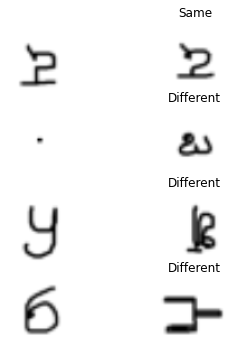

In [12]:
NUMS=4
plt.figure(figsize=(5,NUMS+2));
ii=1
for sample_x,sample_y in zip(source_x[:NUMS],source_y[:NUMS]):
    for takes in sample_x:
        plt.subplot(NUMS,WAYS,ii);plt.imshow(takes[...,0],"gray");plt.axis("off")
        
        ii+=1
    rslt="Same" if sample_y[0] else "Different"
    plt.title(rslt)

# 建立模型
Base model的話範例使用兩層Convolution做為主要network，選ReLu activation且每層中有max pooling和drop out。output前使用兩層MLP化為一個50維向量。

In [13]:
def build_base_network(input_shape):
    seq = Sequential()
    
    nb_filter = [128,128]
    kernel_size = 3
    #convolutional layer 1
    seq.add(Convolution2D(nb_filter[0], kernel_size, kernel_size, input_shape=input_shape,
                           padding="valid",activation='relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2)))  
    seq.add(Dropout(.25))
    
    #convolutional layer 2
    seq.add(Convolution2D(nb_filter[1], kernel_size, kernel_size, padding="valid",activation='relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2))) 
    seq.add(Dropout(.25))

    #flatten 
    seq.add(Flatten())
    seq.add(Dense(128, activation='relu'))
    seq.add(Dropout(0.1))
    seq.add(Dense(50, activation='relu'))
    return seq

'''計算latent距離'''
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))
'''給Lambda layer用的'''
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)
'''計算距離，可自訂prediction是要多小才算兩者同類'''
def accu(labels,predictions):
    return K.mean((labels==1)==(predictions<0.5))

接著引導兩個不同影像分別輸進base_network，輸出feat_vecs_a、feat_vecs_b再計算euclidean distance。
Model 使用RMSprop做 optimization。

In [14]:
'''比一般Model input要多一個rank, 區分一次要比較的每一張照片'''
input_dim = (1+QUERIES,W,H,CH)
imgs = Input(shape=input_dim)
base_network = build_base_network(input_dim[1:])

'''算好support latent'''
support_vec=base_network(imgs[:,0,...])
pred=[]
for qq in range(QUERIES):
    '''算query latent'''
    query_vec=base_network(imgs[:,1+qq,...])
    '''算距離'''
    pred.append(Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([support_vec,query_vec]))
distance=tf.concat(pred,axis=-1)

model = Model(inputs=imgs, outputs=distance)

# 模型訓練
訓練使用10 epoch、batch size為16個pairs，並指定loss function為contrastive_loss。
在訓練時再使用validation split驗證loss是否下降，或者只是over fitting。

In [15]:
lr=0.001
'''同類的時候套用左邊的式子，不同類時套用右邊的式子'''
def contrastive_loss(isgenuine, y_pred):
    margin = 1
    return K.mean(isgenuine * K.square(y_pred) + (1 - isgenuine) * K.square(K.maximum(margin - y_pred, 0)))
'''套用RMSProp optimizer，要的話也可以試Adam'''
rms = RMSprop(learning_rate=lr)

model.compile(loss=contrastive_loss, optimizer=rms,metrics=[accu])

In [16]:
EPOCHS=400
'''開一些callbacks紀錄、調整lr、自動結束訓練'''
reduce_lr = cb.ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=5, min_lr=1e-8, verbose=1)
tensorboard = cb.TensorBoard(log_dir="tf_siamese_logs")
earlystop=cb.EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True, verbose=1)

# %%time
try:
    '''用同個generator來validate也還好，因為每次都是不同task'''
    model.fit(data_source, epochs=EPOCHS, verbose=1,workers=4,callbacks=[reduce_lr,earlystop, tensorboard], validation_data=data_source)
except KeyboardInterrupt:
    print("KeyboardInterrupt")

Epoch 1/400
      1/Unknown - 0s 96us/step - loss: 0.3332 - accu: 0.5312WARNING:tensorflow:From /opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
49/49 [==============================] - 75s 2s/step - loss: 0.2597 - accu: 0.5055 - val_loss: 0.2779 - val_accu: 0.5407
Epoch 2/400
49/49 [==============================] - 0s 7ms/step - loss: 0.2396 - accu: 0.5715 - val_loss: 0.2343 - val_accu: 0.6059
Epoch 3/400
49/49 [==============================] - 0s 7ms/step - loss: 0.2340 - accu: 0.6035 - val_loss: 0.2212 - val_accu: 0.6330
Epoch 4/400
49/49 [==============================] - 0s 7ms/step - loss: 0.2245 - accu: 0.6195 - val_loss: 0.2090 - val_accu: 0.6550
Epoch 5/400
49/49 [==============================] - 0s 8ms/step - loss: 0.2215 - accu: 0.6290 - val_loss: 0.2032 - val_accu: 0.67

# 預測結果
最後使用test data看accuracy，為distance取一個區間(e.g. 0.1)做為評判是否為同個類別的依據。

In [19]:
model.evaluate(data_target)

49/49 [==============================] - 112s 2s/step - loss: 0.2250 - accu: 0.6604


[0.22495028376579285, 0.6603953838348389]

distance有可能>1

# References
[github](https://github.com/shruti-jadon/Hands-on-One-Shot-Learning)

[Paper](https://proceedings.neurips.cc/paper/1993/file/288cc0ff022877bd3df94bc9360b9c5d-Paper.pdf)